In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys


In [3]:
os.chdir("..")
sys.path.append("data")
sys.path.append("src")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
from data_pipeline import read_jsons_from_zip, preprocess_ingredients, cluster_recipes, elbow_method_scratch, elbow_method, reduce_pca, get_similar_recipes
from evaluation import plot_elbow, plot_pca, classification_report

In [5]:
df_test = read_jsons_from_zip("data/test.json.zip")
df_train = read_jsons_from_zip("data/train.json.zip")

In [6]:
df_train.head()
df_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [7]:
df, tfidf_matrix, tfidf_array, vectorizer= preprocess_ingredients(df_train)

In [8]:
print(df.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  39774 non-null  int64 
 1   cuisine             39774 non-null  object
 2   ingredients         39774 non-null  object
 3   joined_ingredients  39774 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None


In [9]:
inertia = elbow_method(tfidf_matrix)

In [10]:
print(inertia)

[36584.513305491564, 36014.658838508505, 35640.1647734713, 35333.00437009649, 35097.68513693962, 34850.21884463766, 34654.23586066129, 34422.93925251207, 34244.10303560549, 34206.3833782562, 34018.55093551836, 33902.483652436145, 33704.220861373746]


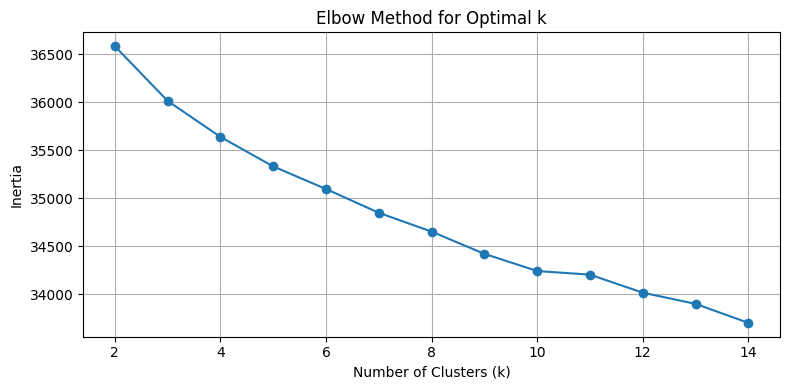

In [11]:
plot_elbow(inertia)

In [12]:
model, labels = cluster_recipes(tfidf_matrix, k=10)

In [13]:
print(model)
print(labels.shape)

KMeans(n_clusters=10, random_state=42)
(39774,)


In [14]:
reduced = reduce_pca(tfidf_array)
print(reduced.shape)

(39774, 2)


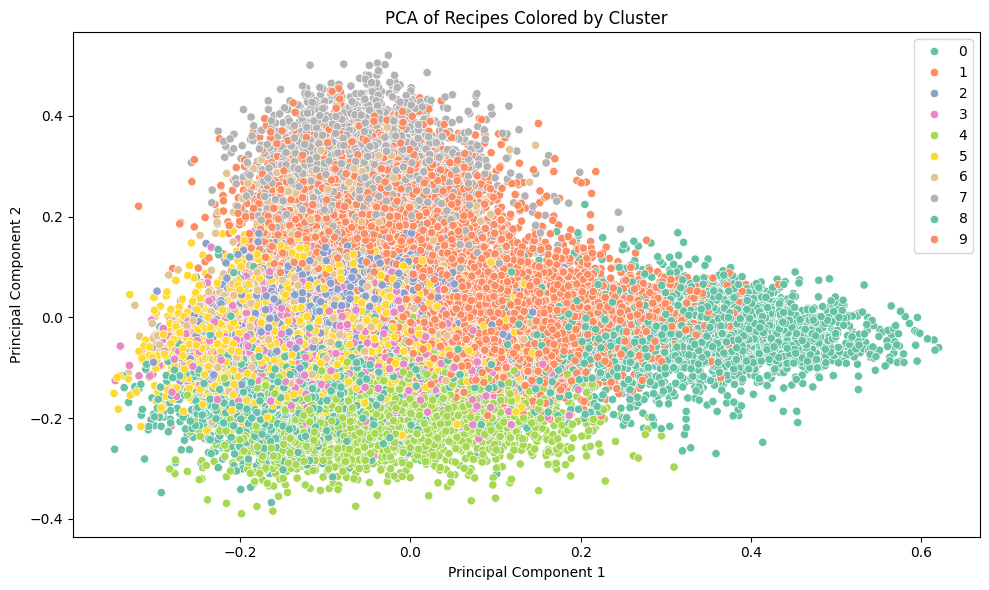

In [15]:
plot_pca(reduced, labels)

In [16]:
# centroids, labels = cluster_recipes(tfidf_array, n_clusters=10)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume you have one new ingredient list
ingredients_list = ['chicken', 'salt', 'pepper', 'garlic']
joined = ' '.join(ingredients_list)
vector = vectorizer.transform([joined])  # shape (1, n_features)

# Compare to full matrix
similarities = cosine_similarity(vector, tfidf_matrix)

# Get top 5 matches
similar_scores = list(enumerate(similarities[0]))
top_matches = sorted(similar_scores, key=lambda x: x[1], reverse=True)[0:5]

for i, score in top_matches:
    print(f"Match ID: {df.iloc[i]['id']} | Score: {score:.4f}")


Match ID: 22375 | Score: 0.6131
Match ID: 16722 | Score: 0.6043
Match ID: 22720 | Score: 0.5580
Match ID: 17244 | Score: 0.5175
Match ID: 49110 | Score: 0.5119


In [18]:
classification_report(tfidf_array,labels)

Silhouette Score: 0.0191
Calinski-Harabasz Index: 364.1719
Davies-Bouldin Index: 5.8286



In [19]:
import joblib
joblib.dump(model, 'models/kmeans_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']